In [1]:
# Import Statements
import pandas as pd
from itertools import combinations
from scipy.stats import multivariate_normal
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import math

In [2]:
# Laoding LD and beta_marginal
LD = pd.read_csv('LD.csv.gz', compression='gzip')
beta_marginal = pd.read_csv('beta_marginal.csv.gz', compression='gzip')

In [3]:
# Dataset Size -- Global Variable 
N_train = 439 # y'y = N
N_test = 50
M = 100

In [4]:
# E-step
def e_step(snp_list, snp_dict_hyperparameter, snp_dict_parameter, LD, beta_marginal):
    tau_epsilon = snp_dict_hyperparameter["tau_epsilon"]
    tau_beta = snp_dict_hyperparameter["tau_beta"]
    pi = snp_dict_hyperparameter["pi"]
    for snp_j in snp_list:
        tau_star_beta = get_tau_star_beta(snp_j, tau_epsilon, tau_beta, LD)
        mu_star_beta = get_mu_star_beta(snp_j, snp_list, tau_epsilon, tau_star_beta, snp_dict_parameter, beta_marginal, LD)
        mu = get_mu(snp_j, tau_beta, pi, tau_star_beta, mu_star_beta)
        gamma_star = get_gamma_star(mu)
        gamma_star = round(gamma_star,3)
        if gamma_star < 0.01:
            gamma_star = 0.01
        if gamma_star > 0.99:
            gamma_star = 0.99
        a_dict = {"mu_star_beta": mu_star_beta, "tau_star_beta": tau_star_beta,"gamma_star": gamma_star}
        snp_dict_parameter[snp_j] = a_dict
    return snp_dict_parameter
        
def get_tau_star_beta(snp_j, tau_epsilon, tau_beta, LD):
    XX = list(LD.loc[LD["Unnamed: 0"] == snp_j][snp_j])[0]
    XX = XX * N_train
    result = (XX * tau_epsilon) + tau_beta
    return result

def get_mu(snp_j, tau_beta, pi, tau_star_beta, mu_star_beta):
    result =  math.log((pi/(1-pi)))
    result = result + ((1/2) *  math.log(tau_beta/tau_star_beta))
    result = result + (tau_star_beta/2 * (mu_star_beta ** 2))
    return result

def get_gamma_star(mu):
    return (1/(1 + math.exp(-mu)))

def get_mu_star_beta(snp_j, snp_list, tau_epsilon, tau_star_beta, snp_dict_parameter, beta_marginal, LD):
    result =  N_train*(tau_epsilon/tau_star_beta)
    Xy = list(beta_marginal.loc[beta_marginal["Unnamed: 0"] == snp_j]["V1"])[0]
    Xy = Xy * N_train
    result = result * ((Xy/N_train) - (get_sum_e_step(snp_j, snp_list, snp_dict_parameter, LD)))
    return result
    
# Helper method
def get_sum_e_step(snp_j, snp_list, snp_dict_parameter, LD):
    result = 0
    for snp_i in snp_list:
        if snp_i == snp_j:
            continue
        value_1 = snp_dict_parameter[snp_i]["mu_star_beta"] * snp_dict_parameter[snp_i]["gamma_star"]
        value_1 = value_1 * (list(LD.loc[LD["Unnamed: 0"] == snp_i][snp_j])[0])
        result = result + value_1
    return result

In [5]:
# M-step
def m_step(snp_list, snp_dict_parameter):
    sum_1 = 0
    sum_2 = 0
    for snp_j in snp_list:
        mu_star_beta = snp_dict_parameter[snp_j]["mu_star_beta"]
        tau_star_beta = snp_dict_parameter[snp_j]["tau_star_beta"]
        gamma_star = snp_dict_parameter[snp_j]["gamma_star"]
        sum_1 = sum_1 + (gamma_star*((mu_star_beta**2) + (1 / tau_star_beta)))
        sum_2 = sum_2 + gamma_star
    pi = sum_2 / M          
    tau_epsilon = 1
    tau_beta = sum_2 / sum_1
    #tau_beta = 1 / tau_beta   
    snp_dict_hyperparameter = {"tau_epsilon": tau_epsilon, "tau_beta": tau_beta, "pi": pi}
    return snp_dict_hyperparameter

In [6]:
# ELBO Calculation
def get_elbo(snp_list, snp_dict_parameter, snp_dict_hyperparameter):
    sum_1 = get_sum_1(snp_list, snp_dict_parameter, snp_dict_hyperparameter)
    sum_2 = get_sum_2(snp_list, snp_dict_parameter, snp_dict_hyperparameter)
    sum_3 = get_sum_3(snp_list, snp_dict_parameter, snp_dict_hyperparameter)
    sum_4 = get_sum_4(snp_list, snp_dict_parameter, snp_dict_hyperparameter)
    sum_5 = get_sum_5(snp_list, snp_dict_parameter)
    result = sum_1 + sum_2 - sum_3 + sum_4 - sum_5
    return result

# Methods to calculate individual sums
def get_sum_1(snp_list, snp_dict_parameter, snp_dict_hyperparameter):
    v2 = 0
    v3 = 0
    v4 = 0
    j = 0
    for snp_j in snp_list:
        if j == 99:
            continue
        pi = snp_dict_hyperparameter["pi"]
        tau_beta = snp_dict_hyperparameter["tau_beta"]
        tau_epsilon = snp_dict_hyperparameter["tau_epsilon"]
        gamma_star = snp_dict_parameter[snp_j]["gamma_star"]
        mu_star_beta = snp_dict_parameter[snp_j]["mu_star_beta"]
        tau_star_beta = snp_dict_parameter[snp_j]["tau_star_beta"]
        # v1
        v1 = ((N_train / 2) * math.log(tau_epsilon)) - (tau_epsilon/2) * N_train
        # v2
        Xy = list(beta_marginal.loc[beta_marginal["Unnamed: 0"] == snp_j]["V1"])[0]
        Xy = Xy * N_train
        value = (gamma_star * mu_star_beta) * Xy
        v2 = v2 + value
        # v3
        XX = list(LD.loc[LD["Unnamed: 0"] == snp_j][snp_j])[0]
        XX = XX * N_train
        value = (tau_epsilon/2) * gamma_star * ((mu_star_beta**2) + (1/tau_star_beta)) * XX
        v3 = v3 + value
        # v4
        v4 = v4 + get_sum_helper(j, snp_list, snp_dict_parameter, snp_dict_hyperparameter)
        j = j + 1
        
    result = v1 + (tau_epsilon * v2) - v3 - (tau_epsilon * v4)
    return result
    
    
def get_sum_helper(j, snp_list, snp_dict_parameter, snp_dict_hyperparameter):
    result = 0
    snp_j = snp_list[j]
    gamma_star_j = snp_dict_parameter[snp_j]["gamma_star"]
    mu_star_beta_j = snp_dict_parameter[snp_j]["mu_star_beta"]
    for k in range(j + 1, 100):
        snp_k = snp_list[k]
        gamma_star_k = snp_dict_parameter[snp_k]["gamma_star"]
        mu_star_beta_k = snp_dict_parameter[snp_k]["mu_star_beta"]
        XX = list(LD.loc[LD["Unnamed: 0"] == snp_k][snp_j])[0]
        XX = XX * N_train
        result = result + (gamma_star_j * mu_star_beta_j * gamma_star_k * mu_star_beta_k * XX)
    return result

def get_sum_2(snp_list, snp_dict_parameter, snp_dict_hyperparameter):
    v1 = 0
    v2 = 0
    for snp_j in snp_list:
        pi = snp_dict_hyperparameter["pi"]
        tau_beta = snp_dict_hyperparameter["tau_beta"]
        gamma_star = snp_dict_parameter[snp_j]["gamma_star"]
        mu_star_beta = snp_dict_parameter[snp_j]["mu_star_beta"]
        tau_star_beta = snp_dict_parameter[snp_j]["tau_star_beta"]
        v1 = v1 + ((-1/2)*math.log((2*pi/tau_beta)))
        v2 = v2 + (tau_beta/2) * gamma_star * ( (mu_star_beta**2) + (1/tau_star_beta))
    result = v1 - v2
    return result


def get_sum_3(snp_list, snp_dict_parameter, snp_dict_hyperparameter):
    v1 = 0
    v2 = 0
    for snp_j in snp_list:
        pi = snp_dict_hyperparameter["pi"]
        tau_beta = snp_dict_hyperparameter["tau_beta"]
        gamma_star = snp_dict_parameter[snp_j]["gamma_star"]
        v1 = v1 + ((-1/2)*math.log((2*pi/tau_beta)))
        v2 = v2 + gamma_star * math.log(tau_beta) 
    result = v1 - ((1/2) * v2)
    return result

def get_sum_4(snp_list, snp_dict_parameter, snp_dict_hyperparameter):
    result = 0
    for snp_j in snp_list:
        pi = snp_dict_hyperparameter["pi"]
        gamma_star = snp_dict_parameter[snp_j]["gamma_star"]
        result = result + (gamma_star * math.log(pi) + ((1 - gamma_star) * math.log(1 - pi)))
    return result

def get_sum_5(snp_list, snp_dict_parameter):
    result = 0
    for snp_j in snp_list:
        gamma_star = snp_dict_parameter[snp_j]["gamma_star"]
        result = result + (gamma_star * math.log(gamma_star) + ((1 - gamma_star) * math.log(1 - gamma_star)))
    return result

In [7]:
# Method to run iteration n times
def run_iteration(snp_list, snp_dict_parameter, snp_dict_hyperparameter, LD, beta_marginal, iternation = 10):
    n = 0
    elbo_list = []
    new_par_dict = snp_dict_parameter
    new_hyperpar_dict = snp_dict_hyperparameter
    while(n != iternation):
        new_par_dict = e_step(snp_list, new_hyperpar_dict, new_par_dict, LD, beta_marginal)
        new_hyperpar_dict = m_step(snp_list, new_par_dict) 
        elbo = get_elbo(snp_list, new_par_dict, new_hyperpar_dict)
        elbo_list.append(elbo)
        n = n + 1
    return elbo_list, new_par_dict

In [8]:
# Initializing parameters
snp_list = LD["Unnamed: 0"].tolist()
snp_dict_parameter = {}
for a_snp in snp_list:
    snp_dict_parameter[a_snp] = {"mu_star_beta":0 , "tau_star_beta": 1,"gamma_star": 0.01}
    
N_train = 439 # y'y = N
N_test = 50
M = 100

# Initializing hyperparameters
snp_dict_hyperparameter = {"tau_epsilon": 1, "tau_beta": 200, "pi": 0.01}

# Running the EM algorithm 10 times
list_eblo, final_parameters = run_iteration(snp_list, snp_dict_parameter, snp_dict_hyperparameter, LD, beta_marginal, 10)

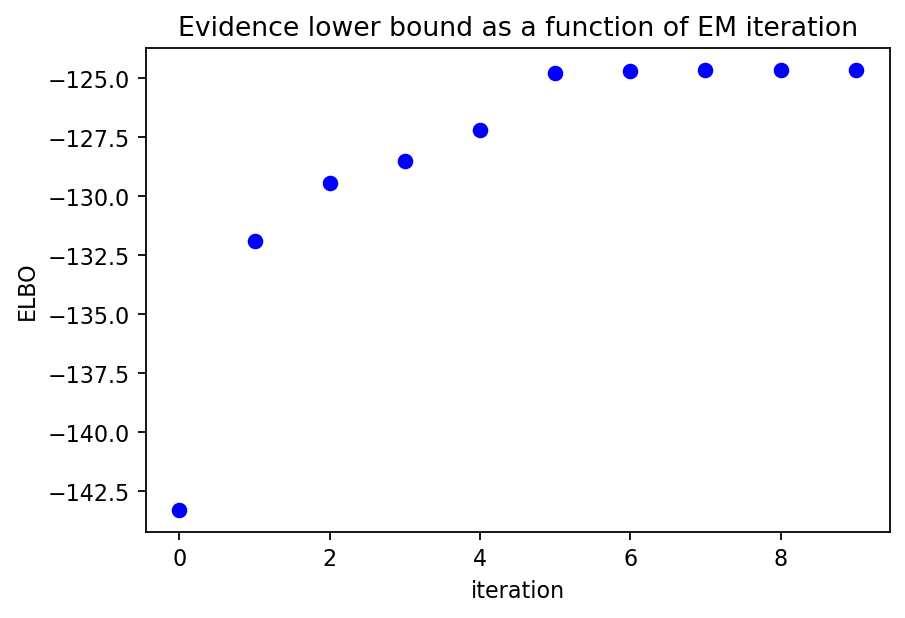

In [9]:
# ELBO results
plt.figure(dpi=160)
plt.plot(list_eblo, 'bo')
plt.xlabel("iteration")
plt.ylabel("ELBO")
plt.title("Evidence lower bound as a function of EM iteration")
plt.show()

In [10]:
# Loading training and testing data
X_train = pd.read_csv('X_train.csv.gz', compression='gzip')
Y_train = pd.read_csv('Y_train.csv.gz', compression='gzip')
X_test = pd.read_csv('X_test.csv.gz', compression='gzip')
Y_test = pd.read_csv('Y_test.csv.gz', compression='gzip')

In [11]:
# Data preparation
all_snps = list(X_train)
all_snps.remove("Unnamed: 0")
Y_train_values = Y_train["V1"].tolist()
Y_test_values = Y_test["V1"].tolist()

In [12]:
# Method fot PRS prediction
def get_y_cap(x_array):
    rows , cols = x_array.shape
    y_cap = []
    for row in range(rows):
        r = x_array.loc[row]
        result = 0
        for snp_j in all_snps:
            result = result + (r.loc[snp_j] * final_parameters[snp_j]["gamma_star"] * final_parameters[snp_j]["mu_star_beta"])
        y_cap.append(result)
    return y_cap
            
y_cap_train = get_y_cap(X_train)  
y_cap_test = get_y_cap(X_test)  

Training PCC is: 69.36%
Training PCC is: 50.25%


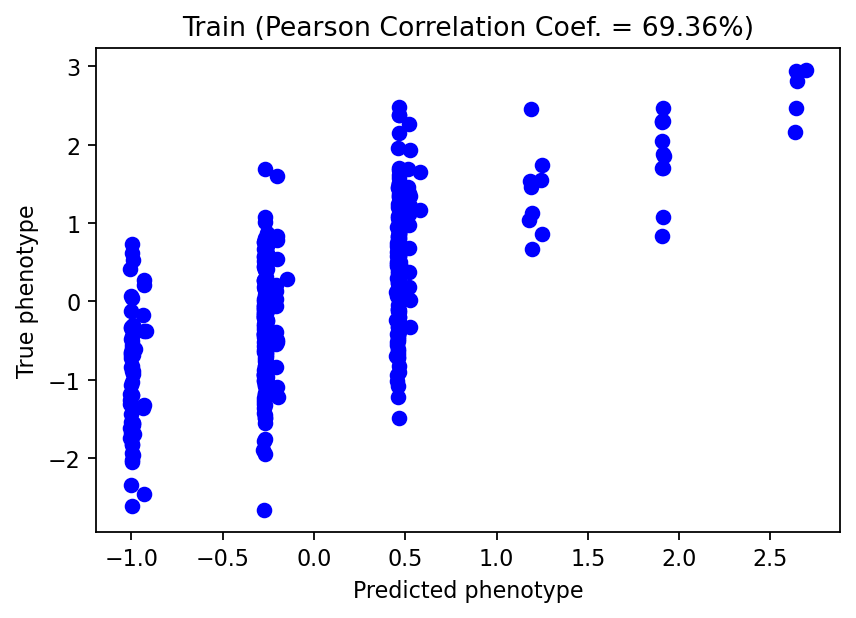

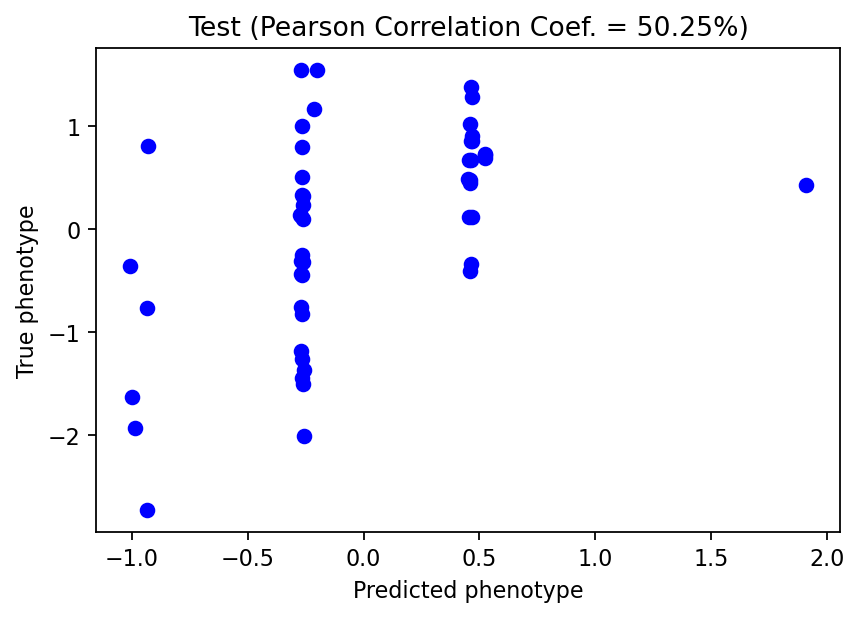

In [13]:
# Calculating the Pearson correlation coefficient (PCC)
pcc_train_mat = np.corrcoef(y_cap_train, Y_train_values)
pcc_test_mat = np.corrcoef(y_cap_test, Y_test_values)

pcc_train = round((pcc_train_mat[1][0]*100),2)
pcc_test = round(pcc_test_mat[1][0]*100,2)

print("Training PCC is: " + str(pcc_train) + "%")
print("Training PCC is: " + str(pcc_test) + "%")

# Scattering Plot for traing and testing
plt.figure(dpi=160)
plt.plot(y_cap_train, Y_train_values, 'bo')
plt.xlabel("Predicted phenotype")
plt.ylabel("True phenotype")
plt.title("Train (Pearson Correlation Coef. = " + str(pcc_train) + "%)")
plt.show()

plt.figure(dpi=160)
plt.plot(y_cap_test, Y_test_values, 'bo')
plt.xlabel("Predicted phenotype")
plt.ylabel("True phenotype")
plt.title("Test (Pearson Correlation Coef. = " + str(pcc_test) + "%)")
plt.show()

PIP values of casual snps are as follows
rs9482449: 0.133
rs7771989: 0.99
rs2169092: 0.99



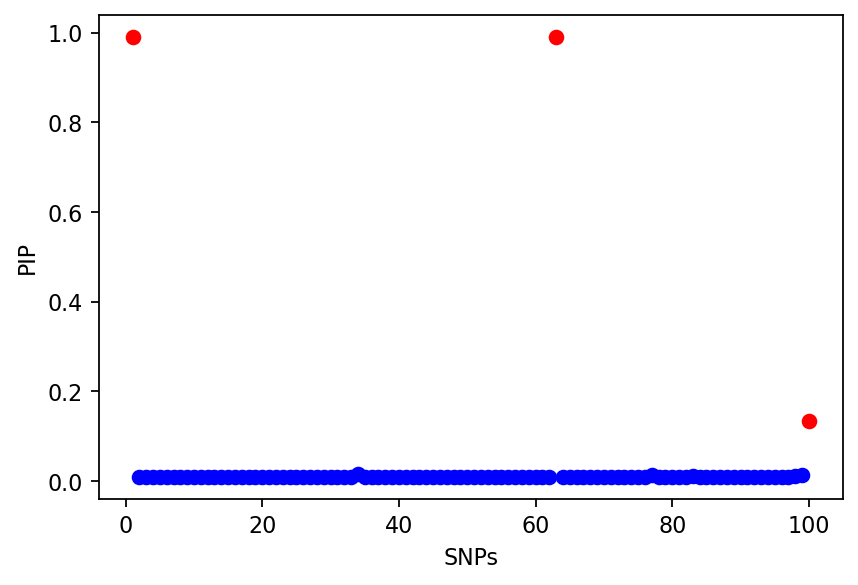

In [14]:
print("PIP values of casual snps are as follows")
print("rs9482449: " + str(round(final_parameters["rs9482449"]["gamma_star"],3)))
print("rs7771989: " + str(round(final_parameters["rs7771989"]["gamma_star"],3)))
print("rs2169092: " + str(round(final_parameters["rs2169092"]["gamma_star"],3)))

print("")


# Plot for Inferred PIP
n = 1
plt.figure(dpi=160)
for snp_j in final_parameters:
    if final_parameters[snp_j]["gamma_star"] < 0.1:
        plt.plot(n, round(final_parameters[snp_j]["gamma_star"],3), 'bo')
    else:
        plt.plot(n, round(final_parameters[snp_j]["gamma_star"],3), 'ro')
    n = n + 1
plt.xlabel("SNPs")
plt.ylabel("PIP")
plt.show()
